# Metehan Gelgi

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[0.0,2.5],
                        [-2.5,-2.0],
                        [2.5,-2.0]])
# standard covariance parameters
class_covariances = np.array([[[3.2,0.0],
                               [0.0,1.2]],
                              
                              [[1.2,0.8],
                               [0.8,1.2]],
                              
                              [[1.2,-0.8],
                               [-0.8,1.2]]])
# sample sizes
class_sizes = np.array([120, 80, 100])

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[2])
X = np.vstack((points1, points2, points3))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

In [4]:
# write data to a file
np.savetxt("HW01_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

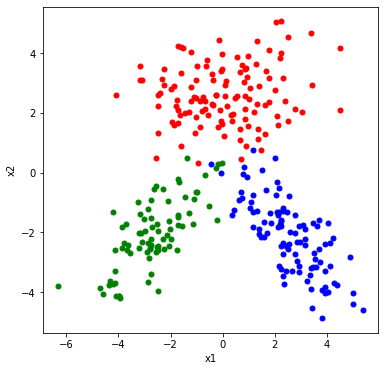

In [5]:
# plot data points generated
columns = ["x1","x2"]
plt.figure(figsize=(6, 6))
plt.plot(points1[:, 0], points1[:, 1], "r.", markersize=10)
plt.plot(points2[:, 0], points2[:, 1], "g.", markersize=10)
plt.plot(points3[:, 0], points3[:, 1], "b.", markersize=10)

plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()

In [6]:
# read data into memory
data_set = np.genfromtxt("HW01_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y_truth)
N = data_set.shape[0]

$\hat{\mu} = \dfrac{\sum\limits_{i = 1}^{N} x_{i}}{N}$

In [7]:
# calculate sample means
sample_means = [np.mean(X[y_truth == (c + 1)], axis=0) for c in range(K)]

print("\033[4msample_means\033[0m \n")
for sample_mean in sample_means:
    print(sample_mean,"\n")

sample_means 

[0.04453807 2.61225132] 

[-2.65871584 -2.04611636] 

[ 2.5605445  -2.12492713] 



$\hat{\Sigma} = \dfrac{\sum\limits_{i = 1}^{N} (x_{i} - \widehat{\mu_{c}}) (x_{i} - \widehat{\mu_{c}})^{T}}{N}$

In [8]:
# calculate sample covariences
# in this code there is something that I couldn't handle it. in sample covarience formula we have (xi - mu)(xi-mu)T
# However in the code, whenever I do it that way, it creates meaningles matrix. So I tried other way. 
sample_covariances = [
    (np.matmul(np.transpose(X[y == (c + 1)] - sample_means[c]), 
               (X[y_truth == (c + 1)] - sample_means[c])) / class_sizes[c]) for c in range(K)]
print("\033[4msample_covariances\033[0m \n")
for sample_covariance in sample_covariances:
    print(sample_covariance,"\n")

sample_covariances 

[[2.81619315 0.22436505]
 [0.22436505 1.00404695]] 

[[1.42028643 1.01066174]
 [1.01066174 1.36103143]] 

[[ 1.40686636 -1.07838139]
 [-1.07838139  1.5075388 ]] 



$\widehat{P}(y_{i} = c) = \dfrac{\sum\limits_{i = 1}^{N} (y_{i} = c)}{N}$

In [9]:
# calculate prior probabilities
class_priors = [np.mean(y_truth == (c + 1)) for c in range(K)]

print("\033[4mclass_priors\033[0m \n", class_priors)

class_priors 
 [0.4, 0.26666666666666666, 0.3333333333333333]


$W_c=\dfrac{-1}{2} \hat{\Sigma}_{c}^{-1}$

In [10]:
Wc = np.array([np.linalg.inv(sample_covariances[c]) / -2 for c in range(K)])

$w_c=\hat{\Sigma}_{c}^{-1} \hat{\mu_{c}}$

In [11]:
wc = np.array([np.matmul(np.linalg.inv(sample_covariances[c]), sample_means[c]) for c in range(K)])

$w_{c0}=\dfrac{-1}{2}\hat{\mu_{c}}^{T} \hat{\Sigma}_{c}^{-1} \hat{\mu_{c}}- \dfrac{D}{2}\log{(2\pi)}-\dfrac{1}{2}\log{|\hat{\Sigma}_{c}|}+\log{[\hat{P}(y=c)]}$

-> $\dfrac{D}{2}\log{(2\pi)}$

this part will cancel each other out in the score function, since it is constant and has no effect for the results.

In [12]:
wc0 = np.array([-(np.matmul(np.matmul(np.transpose(sample_means[c]), 
                                      np.linalg.inv(sample_covariances[c])),sample_means[c])) / 2 
                - np.log(np.linalg.det(sample_covariances[c])) / 2 
                + np.log(class_priors[c]) for c in range(K)])

print("\033[4mWc\033[0m \n", Wc)
print("\033[4mwc\033[0m \n", wc)
print("\033[4mwc0\033[0m \n", wc0)

Wc 
 [[[-0.18076277  0.04039338]
  [ 0.04039338 -0.50701102]]

 [[-0.74649274  0.55432346]
  [ 0.55432346 -0.77899267]]

 [[-0.78681631 -0.56283   ]
  [-0.56283    -0.73427324]]]
wc 
 [[-0.19493365  2.6452823 ]
 [-1.70100354 -0.24024219]
 [ 1.63741087 -0.23825172]]
wc0 
 [-4.87775153 -3.78251262 -3.4266236 ]


$g_c(x)=x^TW_cx+{w}_c^Tx+w_{c0}$

In [13]:
def score_def(x):
    scores = np.array([0, 0, 0])
    for i in range(K):
        score = np.matmul(np.matmul(np.transpose(x), Wc[i]), x) + np.matmul(np.transpose(wc[i]), x) + wc0[i]
        scores[i] = score
    return scores

In [14]:
g_scores = [score_def(X[i]) for i in range(len(X))]

# by using this I am checking maximum value(maximum g score). Then adds label max one. 

predict = [None] * X.shape[0]
for i in range(len(g_scores)):
    max_g=np.max(g_scores[i])
    if g_scores[i][0]==max_g:
        predict[i]=1
    elif g_scores[i][1]==max_g:
        predict[i]=2
    else :
        predict[i]=3

predicted_label=np.array(predict)

In [18]:
np.shape(g_scores)

(300, 3)

In [15]:
confusion_matrix = pd.crosstab(predicted_label, y_truth, rownames=['y_pred'], colnames=['y_truth'])
print("\033[4mconfusion_matrix\033[0m \n", confusion_matrix)

confusion_matrix 
 y_truth    1   2   3
y_pred              
1        119   1   2
2          1  79   2
3          0   0  96


$g_c(x)=x^TW_cx+{w}_c^Tx+w_{c0}$

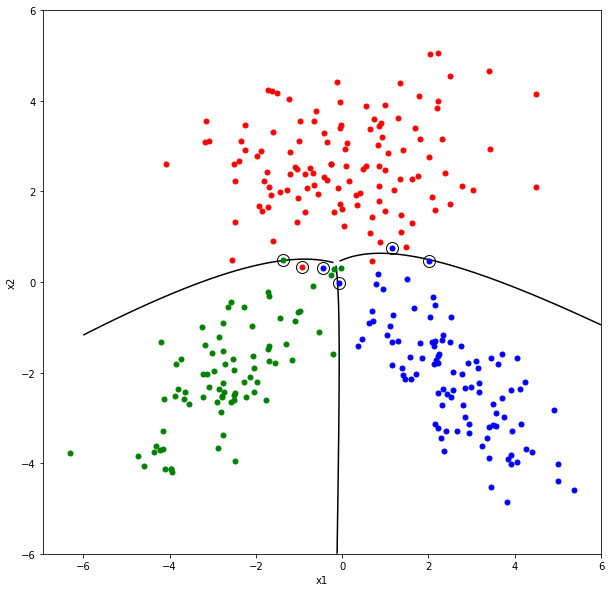

In [40]:
x1_interval = np.linspace(-6, +6, 121)
x2_interval = np.linspace(-6, +6, 121)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
discriminant_values = np.zeros((len(x1_interval), len(x2_interval), K))

# plot figure 
plt.figure(figsize=(10, 10))
plt.plot(X[y_truth == 1, 0], X[y_truth == 1, 1], "r.", markersize=10)
plt.plot(X[y_truth == 2, 0], X[y_truth == 2, 1], "g.", markersize=10)
plt.plot(X[y_truth == 3, 0], X[y_truth == 3, 1], "b.", markersize=10)

# pointing out misclassified points
plt.plot(X[predicted_label != y_truth, 0], X[predicted_label != y_truth, 1], "ko", markersize=12, fillstyle="none")

#for each label calculate discriminant values 
for c in range(K):
    for i in range(x1_grid.shape[0]):
        for j in range(x2_grid.shape[1]):
            x = np.array([x1_grid[i][j],x2_grid[i][j]]).reshape(2,1)
            discriminant_values[i, j, c] = (np.matmul(np.matmul(np.transpose(x),Wc[c]),x)+
                                            np.matmul(np.transpose(wc[c]),x)+
                                            wc0[c])

A = discriminant_values[:, :, 0]
B = discriminant_values[:, :, 1]
C = discriminant_values[:, :, 2]
A[(A < B) & (A < C)] = np.nan
B[(B < A) & (B < C)] = np.nan
C[(C < A) & (C < B)] = np.nan
discriminant_values[:, :, 0] = A
discriminant_values[:, :, 1] = B
discriminant_values[:, :, 2] = C

plt.contour(x1_grid, x2_grid, discriminant_values[:, :, 0] - discriminant_values[:, :, 1], levels=0, colors="k")
plt.contour(x1_grid, x2_grid, discriminant_values[:, :, 0] - discriminant_values[:, :, 2], levels=0, colors="k")
plt.contour(x1_grid, x2_grid, discriminant_values[:, :, 1] - discriminant_values[:, :, 2], levels=0, colors="k")



plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.show()